# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [188]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = sum(data['income'] == '>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k / float(n_records)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

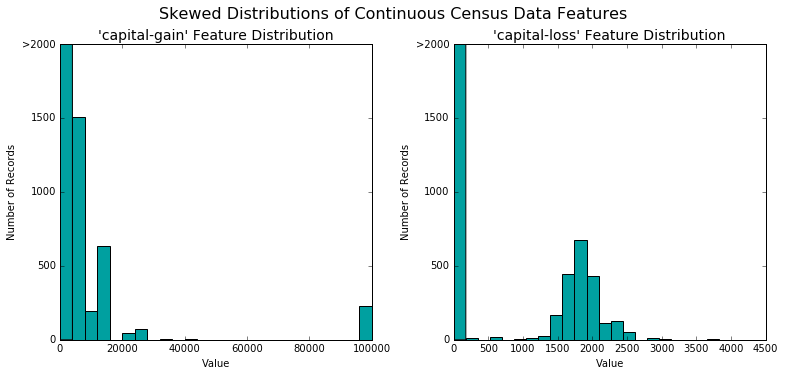

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

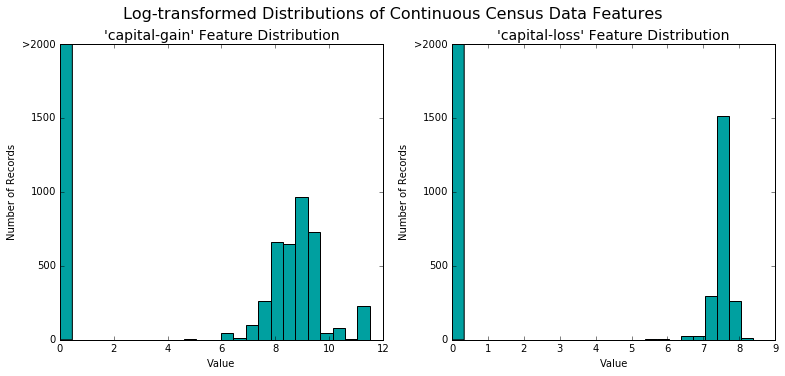

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

Note: This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.  So we can pass in multiple features, and it scales each feature independently of the others.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

pd.get_dummies() converts the categorical columns and keeps numerical columns as is

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = [1 if x=='>50K' else 0 for x in income_raw]

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = \
    train_test_split(features,
                     income,
                     test_size = 0.2,
                     random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [189]:
# TODO: Calculate accuracy

true_observations = float(sum(y_test))
predictions_true = float(len(y_test)) #predicts all observations as true
correct_predictions = float(sum(y_test))
observations = float(len(y_test))
accuracy = correct_predictions / observations

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
#precision is: out of all predictions of true, how many are actually true?
precision = correct_predictions / predictions_true

#recall is: out of all true observations, how many were predicted as true?
recall = correct_predictions / true_observations
fscore = (1+ beta**2) * (precision * recall) / (beta**2 * precision + recall)

# Print the results 
print "precision {} recall {}".format(precision,recall)
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

precision 0.243781094527 recall 1.0
Naive Predictor: [Accuracy score: 0.2438, F-score: 0.2872]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

I'm choosing gradient boost, AdaBoost, and logistic regression.  Boosting methods using decision trees as base learners can process features that are not scaled and not necessarily linearly separable.  Logistic regression training and prediction times are short.  Logistic regression is sensitive to outliers, but we applied log to those features that had very skewed data, to make them more normally distributed.  Logistic regression is also less likely to overfit compared to decision trees.

#### AdaBoost
Applications: computer vision, web search results

Strengths: High Accuracy, handles noise and missing data, doesn't need features to be scaled when it's using decision trees as base learners (decision trees don't need features to be scaled because trees process one feature at a time, and do not calculate distances based on more than one feature).  Dimensions (number of features) don't need to be reduced in order for the model to make accurate predictions. AdaBoost is computationally efficient (because each weak learner that is trained is saved as is, and not revised during training of the following weak learners).

Weaknesses: runtime increases with size of training data, and training of weak learners can't be run in parallel, because each one can only start training after the previous one completes).

Applicable to this data set: because it does not assume the features are independent, and does not require features to be first scaled, selected, or normalized.

https://www.coursera.org/learn/ml-classification/lecture/3ywWA/the-boosting-question
http://media.nips.cc/Conferences/2007/Tutorials/Slides/schapire-NIPS-07-tutorial.pdf


#### Gradient Boost
Applications: used in face detection, web search rankings, and ecology.

Strengths: Same as AdaBoost.

Weaknesses: Same as AdaBoost.

Applicable to this data set: same as for AdaBoost.

http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

#### Logistic Regression
Applications: sentiment analysis of text.


Strengths: fast, does not need feature scaling, and can handle many features.  It has low variance, so it is less likely to overfit training data (compared to decision trees).  Logistic Regression works well when there is a single linear decision boundary between two classes.  By comparison, decision trees can only divide the data along one feature (axis) at a time, so it assume a decision boundary that is a path of lines that only move parallel or perpendicular to each axis.

Weaknesses: Logistic regression doesn't work well when features are correlated.  When features are correlated, logistic regression will over-emphasize the importance of these features.  Logistic regression also assumes that classes are linearly separable, so it won't work as well when the data is not linearly separable. Logistic regression is sensitive to outliers. 

Applicable to this data set: The features have been scaled and normalized to reduce the impact of outliers, which will help improve the performance of logistic regression.  The data may be linearly separable, so logistic regression will look for this linear separation.

https://www.coursera.org/learn/ml-classification/lecture/HNKIj/linear-classifiers-a-motivating-example
http://www.ehow.com/info_8574447_disadvantages-logistic-regression.html
https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees

#### Decision Trees
Strengths: Decision trees perform feature selection by sequentially choosing the next best feature to split on at each level.  Trees don't need features to be scaled or selected before training, because the model looks at one dimension/feature at a time, so the range of one feature relative to another feature does not matter.  For the same reason, outliers do not affect decision trees.  Trees also don't assume a linear relationship between features, so it can fit when classes are not linearly separable.  

Weaknesses: decision trees tend to overfit the training data.  This also means that the decision tree's boundary changes easily when new or different data is used to train the tree.

http://www.simafore.com/blog/bid/62333/4-key-advantages-of-using-decision-trees-for-predictive-analytics
https://www.techwalla.com/articles/advantages-disadvantages-of-decision-trees

#### Random Forest

Strengths: It reduces over-fitting compared to decision trees and also compared to bagging (because for each tree, it chooses a random subset of features that the sub-tree is allowed to split on, so the sub-trees are less likely to all be the same).

Weaknesses: requires a lot of data, and takes more training time compared to decision trees.


#### Support Vector Machines

Strengths: SVM is less sensitive to outliers, because it focuses on observations that are close to the margin that separates the two classes.

Weaknesses: categorial features need to be converted to binary (one-hot encoding), and features should be scaled (distances are calculated based on more than one feature, so the range of each feature affects the calculations).  Training time increases significantly for large data sets.  SVM takes a lot more computation and runtime as the number of features increases.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [101]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    beta = 0.5 #place more emphasis on precision (most positive predictions are actually positive classes)
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = round(end - start,1);
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    predict_train_sample_size = 300
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:predict_train_sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = round(end - start,1)
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[0:predict_train_sample_size], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[0:predict_train_sample_size], predictions_train, beta=beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

### Compare all models

In [112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier

In [115]:
#Test on 10% of the training set to compare model performance

clf_list = [
            KNeighborsClassifier(), 
            GaussianNB(),
            SVC(),
            LogisticRegression(),
            DecisionTreeClassifier(),
            BaggingClassifier(),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            SGDClassifier()
           ]

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
training_size = X_train.shape[0]
samples_10 = int(0.10 * training_size)

# Collect results on the learners
results_all = {}
for clf in clf_list:
    clf_name = clf.__class__.__name__
    results_all[clf_name] = {}
    results_all[clf_name][0] = \
    train_predict(clf, samples_10, X_train, y_train, X_test, y_test)

KNeighborsClassifier trained on 3617 samples.
GaussianNB trained on 3617 samples.
SVC trained on 3617 samples.
LogisticRegression trained on 3617 samples.
DecisionTreeClassifier trained on 3617 samples.
BaggingClassifier trained on 3617 samples.
RandomForestClassifier trained on 3617 samples.
AdaBoostClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 3617 samples.
SGDClassifier trained on 3617 samples.


In [84]:
#evaluate_all plots performance of multiple classifiers
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score
#plot all results and runtimes
def evaluate_all(results, accuracy, f1, learners_l=None, colors=None):
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    if learners_l == None:
        learners_l = ['KNeighborsClassifier',
                      'GaussianNB',
                      'SVC',
                      'LogisticRegression',
                      'DecisionTreeClassifier',
                      'BaggingClassifier',
                      'RandomForestClassifier',
                      'AdaBoostClassifier',
                      'GradientBoostingClassifier',
                      'SGDClassifier'
                     ]

    # Constants
    bar_width = 0.3
    if colors == None:
        colors = ['#e1f136', #knn yellow
                  '#cd7f0e', #nb orange
                  '#76272d', #svc red
                  '#991351', #LogisticRegression(), magenta
                  '#57b061', #DecisionTreeClassifier(), light green
                  '#307755', #BaggingClassifier(), dark green
                  '#00ff00', #RandomForestClassifier(), bright green
                  '#b7eeff', #AdaBoostClassifier(), light blue
                  '#3473a0', #GradientBoostingClassifier(), dark blue
                  '#ff008d' #SGDClassifier() pink
                 ]
    # Super loop to plot four panels of data
    #for k, learner in enumerate(results.keys()):
    for k, learner in enumerate(learners_l):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(1):

                # Creative plot code
                ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j/3, j%3].set_xlabel("Model type")
                ax[j/3, j%3].set_xticks([])
                #ax[j/3, j%3].set_xlim((-0.1, 3.0))

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    #plot the learners in a specified order
    for i, learner_name in enumerate(learners_l):
        patches.append(mpatches.Patch(color = colors[i], label = learner_name))
    pl.legend(handles = patches, bbox_to_anchor = (-0.80, 2.49), \
               loc = 'upper center', borderaxespad = 0., ncol = 5, fontsize = 'small')

    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 12, y = 1.1)
    pl.tight_layout()
    pl.show()

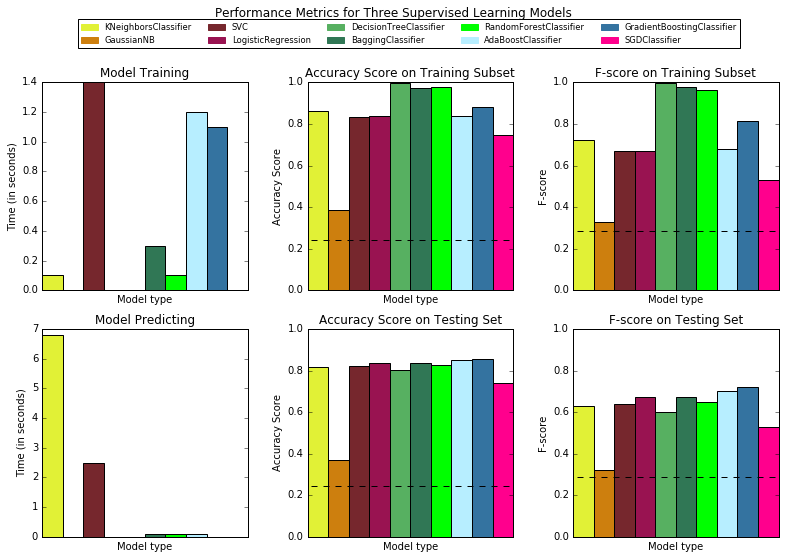

In [116]:
evaluate_all(results_all, accuracy, fscore)

#### Comparing models visually
SVM, AdaBoost, and Gradient Boost takes a long time to train  KNN takes a long time for prediction.  Gradient Boost, AdaBoost, and Bagging logistic regression have high f scores.  Logistic Regression, Gaussian Naive Bayes, Decision Trees, and Stochastic Gradient Descent have nearly zero training and prediction times.

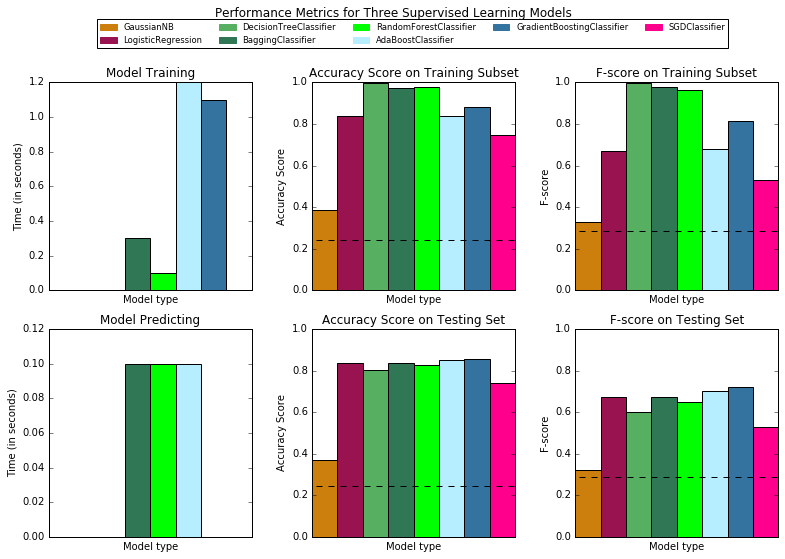

In [117]:
#results excluding SVM and KNN (to compare times of non-outliers)
learners_l = ['GaussianNB',
              'LogisticRegression',
              'DecisionTreeClassifier',
              'BaggingClassifier',
              'RandomForestClassifier',
              'AdaBoostClassifier',
              'GradientBoostingClassifier',
              'SGDClassifier'
             ]

colors = ['#cd7f0e', #nb orange
          '#991351', #LogisticRegression(), magenta
          '#57b061', #DecisionTreeClassifier(), light green
          '#307755', #BaggingClassifier(), dark green
          '#00ff00', #RandomForestClassifier(), bright green
          '#b7eeff', #AdaBoostClassifier(), light blue
          '#3473a0', #GradientBoostingClassifier(), dark blue
          '#ff008d' #SGDClassifier() pink
         ]

evaluate_all(results_all, accuracy, fscore, learners_l, colors)

In [119]:
learners_l = ['KNeighborsClassifier',
                      'GaussianNB',
                      'SVC',
                      'LogisticRegression',
                      'DecisionTreeClassifier',
                      'BaggingClassifier',
                      'RandomForestClassifier',
                      'AdaBoostClassifier',
                      'GradientBoostingClassifier',
                      'SGDClassifier'
                     ]

for learner in learners_l:
    print "classifier {} and training time {}".format(learner,results_all[learner][0]['train_time'])

classifier KNeighborsClassifier and training time 0.1
classifier GaussianNB and training time 0.0
classifier SVC and training time 1.4
classifier LogisticRegression and training time 0.0
classifier DecisionTreeClassifier and training time 0.0
classifier BaggingClassifier and training time 0.3
classifier RandomForestClassifier and training time 0.1
classifier AdaBoostClassifier and training time 1.2
classifier GradientBoostingClassifier and training time 1.1
classifier SGDClassifier and training time 0.0


In [194]:
learners_l = ['KNeighborsClassifier',
                      'GaussianNB',
                      'SVC',
                      'LogisticRegression',
                      'DecisionTreeClassifier',
                      'BaggingClassifier',
                      'RandomForestClassifier',
                      'AdaBoostClassifier',
                      'GradientBoostingClassifier',
                      'SGDClassifier'
                     ]
for learner in learners_l:
    print "classifier {} and test f1 score {:.4f}".format(learner,results_all[learner][0]['f_test'])

classifier KNeighborsClassifier and test f1 score 0.6276
classifier GaussianNB and test f1 score 0.3208
classifier SVC and test f1 score 0.6408
classifier LogisticRegression and test f1 score 0.6746
classifier DecisionTreeClassifier and test f1 score 0.5986
classifier BaggingClassifier and test f1 score 0.6713
classifier RandomForestClassifier and test f1 score 0.6483
classifier AdaBoostClassifier and test f1 score 0.7019
classifier GradientBoostingClassifier and test f1 score 0.7216
classifier SGDClassifier and test f1 score 0.5286


In [121]:
# TODO: Initialize the three models
clf_A = LogisticRegression()
clf_B = AdaBoostClassifier()
clf_C = GradientBoostingClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
training_size = X_train.shape[0]
samples_1 = int(0.01 * training_size)
samples_10 = int(0.10 * training_size)
samples_100 = training_size

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


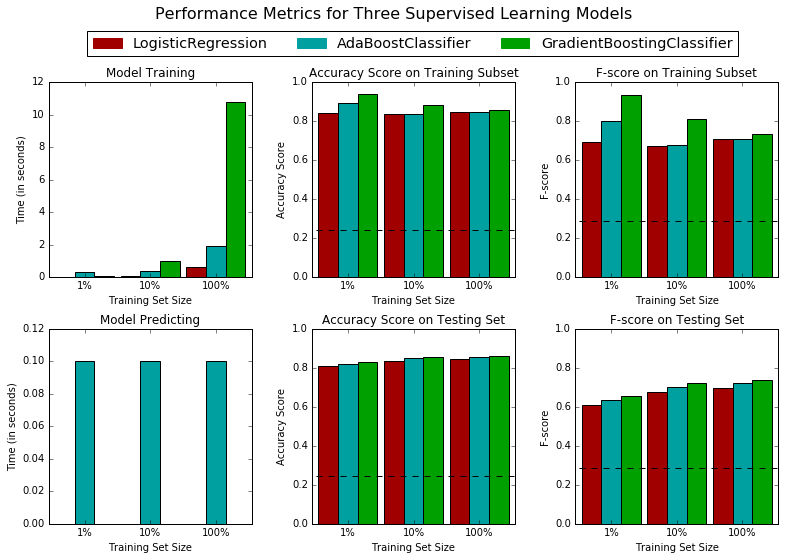

In [122]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [151]:
results

{'AdaBoostClassifier': {0: {'acc_test': 0.82078496406854617,
   'acc_train': 0.89333333333333331,
   'f_test': 0.63301046864298982,
   'f_train': 0.80128205128205132,
   'pred_time': 0.1,
   'train_time': 0.3},
  1: {'acc_test': 0.84986180210060802,
   'acc_train': 0.83999999999999997,
   'f_test': 0.7018820838099199,
   'f_train': 0.68014705882352933,
   'pred_time': 0.1,
   'train_time': 0.4},
  2: {'acc_test': 0.85760088446655613,
   'acc_train': 0.84999999999999998,
   'f_test': 0.72455089820359275,
   'f_train': 0.71153846153846156,
   'pred_time': 0.1,
   'train_time': 1.9}},
 'GradientBoostingClassifier': {0: {'acc_test': 0.82985074626865674,
   'acc_train': 0.93999999999999995,
   'f_test': 0.65592325105098626,
   'f_train': 0.9375,
   'pred_time': 0.0,
   'train_time': 0.1},
  1: {'acc_test': 0.85594250967385299,
   'acc_train': 0.8833333333333333,
   'f_test': 0.72160405420293039,
   'f_train': 0.81349206349206349,
   'pred_time': 0.0,
   'train_time': 1.0},
  2: {'acc_test':

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

In [201]:
print "increase in training time when training sample is increased by 10x"
for learner in ['GradientBoostingClassifier', 'AdaBoostClassifier', 'LogisticRegression']:
    print "{} train time increase by {:.2f}x".format(learner,results[learner][2]['train_time'] / results[learner][1]['train_time'])

increase in training time when training sample is increased by 10x
GradientBoostingClassifier train time increase by 10.80x
AdaBoostClassifier train time increase by 4.75x
LogisticRegression train time increase by 6.00x


**Answer: **

I'm choosing Adaptive Boosting (AdaBoost) to identify individuals who make more than \$50,000.  Adaboost has the second highest F1 score (0.72), where beta is 0.5 (precision is given more emphasis than recall).  

Even though Gradient Boosting gives a slightly higher F1 score (0.74), the model training time increases linearly with the size of training data (increasing the amount of training data by 10x results in a 10x increase in training time).  Adaboost training time increases by 1.3x to 4.7x when training data is increased by 10x).  

Logistic Regression gives slightly lower F1 score than AdaBoost and Gradient Boost (0.67), but its training time is the shortest, and does not increase much with an increase in training data.  It might be a good option if we plan to use much more data to train the model.  

The accuracy scores of the three models have the same relative performance as their F1 scores (Gradient Boost performs better than AdaBoost, which performs better than Logistic Regression).  If the ranking of accuracy did not match the ranking of F1 scores, we should look at the F1 score comparisons, because accuracy is not a good measure when the number of observations for each class are not similar in size (in this case, about 1/4 of the observations are in the income over \$50k class, and 3/4 are in the "under \$50k" class).  

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

AdaBoost trains a series of base classifiers (here we use decision trees as base classifiers, which are most commonly used), taking the input features (for example, work class, education, occupation, sex, capital-gain), as well as the classification for whether persons have incomes greater than 50 thousand dollars, or not.  

AdaBoost first trains one base model (one decision tree), which uses the features to classify each person in one of two income classes.  Then it compares these predictions with the actual class for each person.  For those persons where this base model was incorrect, it gives those observations (persons) more importance (weights them more heavily) when training a second base model (a second decision tree). It continues to train more models, saving every model and adjusting the weights of the data points based on the performance of the previously trained model.  

The actual prediction of the AdaBoost model is a weighted sum of the predictions from all of the base models (from the very first base model trained to the last).  Each base model is given its own weight based on that base model's accuracy across all training examples.  The AdaBoost model stops training new models when it reaches the maximum number of base models allowed (a number that we can choose).

So when the model gets a new person and their features (occupation, education etc), the model will pass this information into each of its base models (for example, 50 base models).  Each base model makes its own prediction, and the overall Adaboost model aggregates all of these 50 predictions to arrive at a final predicted class for that new person.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

#### Notes  

* I noticed that AdaBoostClassifier() without passing in a base estimator was doing better than AdaBoostClassifier(base_estimator = DecisionTreeClassifier()).  Looking at the source code, the default base estimator is actually DecisionTreeClassifier(max_depth=1).  This is a stub, (1-level tree), which is recommended as a weak learner.  If I explicitly pass in DecisionTreeClassifier as a base estimator, the default max_depth is 'None', which means the tree will keep growing and overfit.

* When using grid search, I need to set AdaBoost's base estimator so that grid search can tune the parameters within the base estimator.

* Note that, in order to save grid search time, I use a most 3 values for each parameter at a time, one greater than and one less than the default (or optimal) value.  Based on the results, I know which direction (increase or decrease) that improves the model, and can try other values around the latest best value.  Like binary search, this helps me to narrow down the search space for the parameters.

In [162]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV #grid_search was deprecated; using model_selection instead
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
# TODO: Initialize the classifier
clf_default = AdaBoostClassifier() #default is the same as AdaBoostClassifier(max_depth=1)
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier()) #need to set base_estimator in order for grid search to set the base estimator's arguments
# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [20, 50, 75],
              'base_estimator__max_depth': [1, 2],
             }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)
cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf,
                        param_grid=parameters,
                        scoring=scorer,
                        cv=cv_sets)

# TODO: Fit the grid search object to the training data and find the optimal parameters
start = time()
grid_fit = grid_obj.fit(X_train,y_train)
end = time()
search_duration = round(end - start,0)
print "grid search took {} seconds".format(search_duration)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf_default.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

grid search took 143.0 seconds
Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7424


In [163]:
grid_obj.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=75, random_state=None)

Increasing the number of estimators to 75 and max_depth to 2 improved F-score.  I'll see what happens if I increase them further.

In [164]:
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier()) #need to set base_estimator in order for grid search to set the base estimator's arguments
# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [75,100],
              'base_estimator__max_depth': [2,3],
             }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)
cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf,
                        param_grid=parameters,
                        scoring=scorer,
                        cv=cv_sets)

# TODO: Fit the grid search object to the training data and find the optimal parameters
start = time()
grid_fit = grid_obj.fit(X_train,y_train)
end = time()
search_duration = round(end - start,0)
print "grid search took {} seconds".format(search_duration)

# Get the estimator
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
#print "Unoptimized model\n------"
#print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
#print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

grid search took 222.0 seconds

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7424


In [165]:
grid_obj.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=75, random_state=None)

Increasing max_depth from 2 to 3 does not improve the f score, and increasing the number of estimators from 75 to 100 does not improve the f-score either.

I'll stick with max_depth of 2 and try a few more estimator numbers

In [166]:
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier()) #need to set base_estimator in order for grid search to set the base estimator's arguments
# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [60,75,90],
              'base_estimator__max_depth': [2],
             }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)
cv_sets = ShuffleSplit(n_splits=10, test_size = 0.20, random_state = 0)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf,
                        param_grid=parameters,
                        scoring=scorer,
                        cv=cv_sets)

# TODO: Fit the grid search object to the training data and find the optimal parameters
start = time()
grid_fit = grid_obj.fit(X_train,y_train)
end = time()
search_duration = round(end - start,0)
print "grid search took {} seconds".format(search_duration)

# Get the estimator
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
#print "Unoptimized model\n------"
#print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
#print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

grid search took 124.0 seconds

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7424


In [167]:
grid_obj.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=75, random_state=None)

I don't see an improvement from 75 estimators and max depth of 2, so I'll stop here for now.

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.2438           |    0.8576         |   0.8676        |
| F-score        |    0.2872           |    0.7246         |   0.7424        |


**Answer: **

The optimized model has an F-score of 0.7424 and accuracy of 0.8676, which is slightly better than the un-optimized model.  Both the un-optimized and optimized AdaBoost models perform better than the naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

In [202]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=75)
clf = clf.fit(X_train,y_train)
features_df = pd.DataFrame()
features_df['feature_name'] = list(features.columns)
features_df['feature_importances'] = clf.feature_importances_
features_df = features_df.sort_values(['feature_importances'], ascending=False)
features_df.head(20)

,feature_name,feature_importances
2,capital-gain,0.293333
3,capital-loss,0.173333
0,age,0.133333
4,hours-per-week,0.040000
21,education_level_ Bachelors,0.026667
1,education-num,0.026667
45,occupation_ Protective-serv,0.013333
30,marital-status_ Married-civ-spouse,0.013333
38,occupation_ Exec-managerial,0.013333
39,occupation_ Farming-fishing,0.013333


### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

The 5 most importance features are in order from most importance first:
1: capital gain

2: capital loss

3: age

4: hours worked per week

5: education level

I assume this order of feature importance based on the feature importances found by AdaBoost.  Conceptually the way feature selection works with the decision tree (the base learner), is that the tree looks at each feature that is not already used for splitting the observations, and finds the best feature that will split the data into two classes.  The order in which the trees choose the best feature can be converted to a ranking of the features by their relative importance in determining the class.  Adaboost takes a weighted average over multiple decision trees, so it takes a weighted average of the feature rankings to produce its feature_importance rankings.

http://scikit-learn.org/stable/modules/ensemble.html

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel

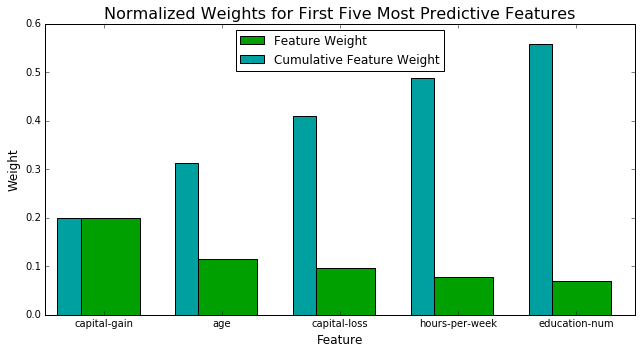

In [182]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=75)
model = model.fit(X_train,y_train)
# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

The aggregates the feature_importances of all the feature columns that were generated using one-hot encoding.  For intance, all education columns are generated from the original education column, so the sum of the feature importance weights for all those education columns represents the feature_importance of the original education column.

This makes more sense than just looking at the feature importance of each individual column separately, since they were generated from one column, and they conceptually represent the same variable (education level, for instance).

So the features ordered by importance are:

1: education level

2: hours worked per week

3: capital loss

4: age

5: capital gain

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [187]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

start = time()
best_clf = best_clf.fit(X_train,y_train)
end = time()
duration_all_features_train = round(end - start,1)

start = time()
best_predictions = best_clf.predict(X_test)
end = time()
duration_all_features_predict = round(end - start,1)

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()

start = time()
duation_reduced_features_train = round(end - start,1)
end = time()
duration_reduced_features_predict = round(end - start,1)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Train time {}, predict time {}".format(duration_all_features_train, duration_all_features_predict)
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Train time {}, predict time {}".format(duration_reduced_features_predict, duration_reduced_features_predict)

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7424
Train time 4.6, predict time 0.1

Final Model trained on reduced data
------
Accuracy on testing data: 0.8429
F-score on testing data: 0.7003
Train time 0.0, predict time 0.0


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

With the reduced features, the F-score is 0.7003 compared with 0.7424 with all features.  The training time is reduced rom 4.6 seconds to nearly zero.  If training time is an issue, I would consider using the reduced data set.  However, if the model does not need to be trained very frequently, and if using more features consistently generates a higher f-score, I would still prefer using more features despite the extra cost in training time and data storage space.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

# Appendix

### References for model comparisons

http://scikit-learn.org/stable/tutorial/machine_learning_map/

http://www.dataschool.io/comparing-supervised-learning-algorithms/

https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice

https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-cheat-sheet

http://stackoverflow.com/questions/2595176/when-to-choose-which-machine-learning-classifier

https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf

### Notes on each model

Gaussian Naive Bayes
strengths: performs well when features are independent.  
weaknesses: does less well when features are correlated, because it assumes independence.

Naive Bayes classifier. This model is much more computationally efficient than optimal Bayes classification, and under certain conditions it has performance comparable to neural networks and decision trees

Decision Trees
strengths: good for non-linear separation.
weaknesses: prone to over-fitting training data.

Decision Trees is one of the popular algorithms for tackling such challenges. Advantages of decision trees include:
● computational scalability
● handling of messy data ­ missing values, various feature types
● ability to deal with irrelevant features ­ the algorithm selects
“relevant” features first, and generally ignores irrelevant features.
● If the decision tree is short, it is easy for a human to interpret it:
decision trees do not produce a black box model.

It compares all available attributes to find which one classifies the data the best, but it doesn’t look ahead (or behind) at other attributes to see which combinations of them classify the data the best. This means that while the algorithm will, in most cases, come up with a good decision tree, a better one may exist


Bagging
http://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/

Bootstrap Aggregation is a general procedure that can be used to reduce the variance for those algorithm that have high variance. An algorithm that has high variance are decision trees, like classification and regression trees (CART).

Decision trees are sensitive to the specific data on which they are trained. If the training data is changed (e.g. a tree is trained on a subset of the training data) the resulting decision tree can be quite different and in turn the predictions can be quite different.

Bagging is the application of the Bootstrap procedure to a high-variance machine learning algorithm, typically decision trees.

When bagging with decision trees, we are less concerned about individual trees overfitting the training data. For this reason and for efficiency, the individual decision trees are grown deep (e.g. few training samples at each leaf-node of the tree) and the trees are not pruned. These trees will have both high variance and low bias. These are important characterize of sub-models when combining predictions using bagging.

http://media.nips.cc/Conferences/2007/Tutorials/Slides/schapire-NIPS-07-tutorial.pdf



AdaBoost

http://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/
AdaBoost was the first really successful boosting algorithm developed for binary classification
The most suited and therefore most common algorithm used with AdaBoost are decision trees with one level. Because these trees are so short and only contain one decision for classification, they are often called decision stumps.


http://stackoverflow.com/questions/20435717/what-is-a-weak-learner
For Adaboost, choose decision tree as a weak learner.
A weak classifier (decision stump) is prepared on the training data using the weighted samples. Only binary (two-class) classification problems are supported, so each decision stump makes one decision on one input variable and outputs a +1.0 or -1.0 value for the first or second class value.


Advantages:
● Computationally efficient.
● No difficult parameters to set.
● Versatile ­ a wide range of base learners can be used with
AdaBoost.
Caveats:
● Algorithm seems susceptible to uniform noise.
● Weak learner should not be too complex ­ to avoid overfitting.
● There needs to be enough data so that the weak learning
requirement is satisfied ­ the base learner should perform consistently better than random guessing, with generalization error < 0.5 for binary classification problems.


RandomForest

http://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
Random Forests are an improvement over bagged decision trees.
In CART, when selecting a split point, the learning algorithm is allowed to look through all variables and all variable values in order to select the most optimal split-point. The random forest algorithm changes this procedure so that the learning algorithm is limited to a random sample of features of which to search.

The number of features that can be searched at each split point (m) must be specified as a parameter to the algorithm. You can try different values and tune it using cross validation.

For classification a good default is: m = sqrt(p)
For regression a good default is: m = p/3
Where m is the number of randomly selected features that can be searched at a split point and p is the number of input variables.

Gradient Boosting

http://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
Gradient Boosting is similar to Adaboost in that it aggregates weak learners to generate a classification model.

https://www.analyticsvidhya.com/blog/2015/05/boosting-algorithms-simplified/

Similar to classifier boosters, we also have regression boosters. In these problems we have continuous variable to predict.

Boosting is one of the most powerful tool used in machine learning. These models suffer the problem of over-fitting if the data sample is too small.


K-Nearest Neighbors

nearest neighbors also suffers from the curse of dimensionality, the idea that as the number of features grow, the amount of data required for accurate generalization grows exponentially.

k nearest neighbors does not provide a way to extrapolate beyond the range observed in the training data

http://machinelearningmastery.com/k-nearest-neighbors-for-machine-learning/

Best Prepare Data for KNN

Rescale Data: KNN performs much better if all of the data has the same scale. Normalizing your data to the range [0, 1] is a good idea. It may also be a good idea to standardize your data if it has a Gaussian distribution.
Address Missing Data: Missing data will mean that the distance between samples can not be calculated. These samples could be excluded or the missing values could be imputed.
Lower Dimensionality: KNN is suited for lower dimensional data. You can try it on high dimensional data (hundreds or thousands of input variables) but be aware that it may not perform as well as other techniques. KNN can benefit from feature selection that reduces the dimensionality of the input feature space.


Stochastic Gradient Descent Classifier
This is applying gradient descent, but instead of processing all data points for each update of weights, it uses one data point to update the weights.  This saves time as the data set size increases, an improves the likelihood with fewer weight updates, but the weights can jump around a lot.
https://www.coursera.org/learn/ml-classification/lecture/d4rdu/stochastic-gradient-learning-one-data-point-at-a-time


Support Vector Machines
http://machinelearningmastery.com/support-vector-machines-for-machine-learning/

A tuning parameter is introduced called simply C that defines the magnitude of the wiggle allowed across all dimensions. The C parameters defines the amount of violation of the margin allowed. A C=0 is no violation and we are back to the inflexible Maximal-Margin Classifier described above. The larger the value of C the more violations of the hyperplane are permitted.

Numerical Inputs: SVM assumes that your inputs are numeric. If you have categorical inputs you may need to covert them to binary dummy variables (one variable for each category).
Binary Classification: Basic SVM as described in this post is intended for binary (two-class) classification problems. Although, extensions have been developed for regression and multi-class classification.

It is important to note that the natural task for SVMs lies in binary classification. For classification tasks involving more than two groups, a common strategy is to use multiple binary classifiers to decide on a single­best class for new instances.


https://www.quora.com/For-what-kind-of-classification-problems-is-SVM-a-bad-approach
SVM doesn't work well if the data is skewed (more data points for one class and fewer for another). The features must be scaled properly, else this affects the results.  SVM training time increases with large data sets.
http://www.sciencedirect.com/science/article/pii/S0925231207002962


Looks like Microsoft's Azure page recommends SVM when there are over 100 features.
https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-cheat-sheet

Logistic Regression
This is like regression, but where the output is converted to a probability by scaling it to be between 0 and 1 (using a sigmoid function).  So logistic regression computes a score as a weighted sum of the input features, and that score is fed into the sigmoid function to get the probability.  If the probability is >0.50, we consider it a "positive" classification, and if < 0.50, it's a negative classification.  This works for a binary classification, where we have just two outcomes that we are predicting.  We use gradient ascent to find the weights that maximize the likelihood function, which is the product of all the probabilities that a classifier's prediction matches the actual class, given the input features.

Note that for gradient ascent, each time that we update the weights to improve the model, we pass through the entire data set.  This will take a long time if we have a large data set.

Logistic regression is simpler and trains faster than, for example, neural networks.


https://www.coursera.org/learn/ml-classification/home/week/2